# Two-layer flow, non-linear flow

There are three parts to this assignment. 

1. Using the method of characteristics to examine the propogation (or lack thereof) of a smoothed tophat perturbation in a two-layer shear flow under various shear strengths
2. Repeating the above experiments with the MITgcm
3. Creating MITgcm simulations with hydraulic jumps and comparing these against analytical solutions for the jump speed


# Method of characteristics

Equations 3.3.13 and 3.3.14 of Baines (1998) described two-layer, non-linear flow (for flat topography) in characteristic form:

$$R_\pm = \sin^{-1}\left(\frac{2\eta + d_{10} - d_{20}}{D} \right) + \sin^{-1} \left(\frac{v}{\sqrt{g' D}} \right) = \mathrm{constant}$$

on

$$\frac{\mathrm{d} x}{\mathrm{d} t} = c_\pm = \frac{Q}{D} + \frac{v(d_{20} - d_{10} - 2\eta)}{D} \pm \sqrt{\left(g' - \frac{v^2}{D} \right) \frac{(d_{20} - \eta)(d_{10} + \eta)}{D}}$$

The variables in this system are $\eta$, the height of the interface above its mean value, and $v$ the difference in flow velocity between the two layers: $v = u_1 - u_2$.

The constants for a given configuration are 

* $d_{10}$: the thickness of the bottom layer far upstream
* $d_{20}$: the thickness of the top layer far upstream
* $u_1$: the velocity of the bottom layer
* $u_2$: the velocity of the top layer
* $g'$: the reduced gravity
* $D$: the total depth

The equations above can be solved for $\eta$ and $v$:

$$\eta = \frac{1}{2}\left(D \sin \left(\frac{R_+ + R_\mathrm{-}}{2} \right) - d_{10} + d_{20} \right)$$

$$v = \sqrt{g' D} \sin \left(\frac{R_+ - R_\mathrm{-}}{2}\right)$$

Here we analyse the evolution of shear flow under various combinations of shear and thickness ratios. In each case, the initial interface is given by a smoothed tophat.

## Code

### Imports and core functions

In [19]:
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
%matplotlib inline


def interp(x, y):
    """Save me specifying extrapolate everytime"""
    return interp1d(x, y, fill_value='extrapolate')


def starting_interface(x, A, w):
    """Smoothed tophat centred about 0 with amplitude A and width w"""
    interface = np.zeros_like(x)
    interface[np.logical_and(x > -w/2, x < w/2)] += A
    interface = gaussian_filter1d(interface, sigma=7)
    return interface


def calc_c(eta, v, k):
    """Calculate wavespeed (equivalently the characteristics)

    Divide into three parts, the three terms in Eq 3.3.14 of Baines (1998)"""
    u_10, d_10, u_20, d_20 = k.u_10, k.d_10, k.u_20, k.d_20

    c_1 = (u_10*d_10 + u_20*d_20)/D
    c_2 = v*(d_20 - d_10 - 2*eta)/D
    c_3_sq = (g - v**2/D)*(d_20 - eta)*(d_10 + eta)/D
    # c_3_sq = c_3_sq.clip(min=0)
    c_plus = c_1 + c_2 + np.sqrt(c_3_sq)
    c_minus = c_1 + c_2 - np.sqrt(c_3_sq)

    return c_plus, c_minus


def calc_R(eta, v, k):
    """Calculate Riemann invariants

    Break into two terms, the terms in Equation 3.3.13 of Baines (1998)"""
    d_10, d_20 = k.d_10, k.d_20

    R_1_arg = (2*eta + d_10 - d_20)/D
    R_2_arg = v/np.sqrt(g*D)

    R_1 = np.arcsin(R_1_arg.clip(max=1))
    R_2 = np.arcsin(R_2_arg)

    R_plus = R_1 + R_2
    R_minus = R_1 - R_2

    return R_plus, R_minus


def solve_for_eta_v(R_plus, R_minus, k):
    """Solve system of Equations 3.3.13 of Baines (1998) for eta and v

    Two equations since plus and minus"""
    d_10, d_20 = k.d_10, k.d_20

    eta = 0.5*(D*np.sin((R_plus + R_minus)/2) - d_10 + d_20)
    v = np.sqrt(g*D)*np.sin((R_plus - R_minus)/2)

    return eta, v


def integrate_characteristics(r, u_10, u_20, A):
    """Integrate two-layer flow using method of characteristics
    
    Inputs
    ------
    r: float
        Fraction of depth occupied by bottom layer
    u_10: float
        Velocity of bottom layer scaled by (g' D)^0.5
    u_20: float
        Velocity of top layer scaled by (g' D)^0.5
    A: float
        Amplitude of initial displacement scaled by D
    
    Returns
    -------
    eta_mat: Nt x Nx array
        Interface height anomaly
    v_mat: Nt x Nx array
        Shear
    """
    
    u_10 *= np.sqrt(g*D)
    u_20 *= np.sqrt(g*D)
    d_10 = D*r
    d_20 = D*(1 - r)
    v_0 = u_10 - u_20
    
    class FlowConfig():
        def __init__(self, _10, u_20, d_10, d_20):
            self.u_10 = u_10
            self.u_20 = u_20
            self.d_10 = d_10
            self.d_20 = d_20
            self.g = g
            self.D = D
    
    FlowConfig = FlowConfig(u_10, u_20, d_10, d_20)
    
    # Preallocate output and fill zeroth time step
    eta_mat = np.empty((Nt + 1, Nx))
    v_mat = np.empty((Nt + 1, Nx))
    eta_mat[0] = starting_interface(x, A=A, w=int(len(x)/10))
    v_mat[0] = v_0*np.ones_like(x)

    for i, t_i in enumerate(t, start=1):

        # Values from previous time step
        eta_im1 = eta_mat[i-1]
        v_im1 = v_mat[i-1]
        R_plus_im1, R_minus_im1 = calc_R(eta_im1, v_im1, FlowConfig)
        R_plus = interp(x, R_plus_im1)
        R_minus = interp(x, R_minus_im1)

        # Project back along characteristics from t+1 to t
        c_plus, c_minus = calc_c(eta_im1, v_im1, FlowConfig)
        x1 = x - c_plus*delta_t
        x2 = x - c_minus*delta_t

        # Calculate Riemann invariants
        R_plus_x1 = R_plus(x1)
        R_minus_x2 = R_minus(x2)

        eta_i, v_i = solve_for_eta_v(R_plus_x1, R_minus_x2, FlowConfig)

        # Save current time step
        eta_mat[i] = eta_i
        v_mat[i] = v_i
    
    return eta_mat, v_mat, FlowConfig

### Analysis functions

In [47]:
def waterfall(ax, eta_mat, t_step=200):
    for i in range(0, len(t), t_step):
        ax.plot(x, eta_mat[i, :] + 0.02*i/t_step, 'k')
    ax.set(title='Evolution of interface with time', xlim=(x[0], x[-1]))


def initial_conditions(ax, eta_mat, config):
    # Interface
    ax.fill_between(x, eta_mat[0] + config.d_10, 0, color='lightgrey')
    ax.plot(x, eta_mat[0] + config.d_10, color='grey')
   
    # Shear
    k = config
    enlarge = 100
    quiver_props = dict(angles='xy', scale_units='xy', scale=1, pivot='middle')
    text_props = dict(va='bottom', ha='center')
    x1, y1, dx1, dy1 = 0, k.d_10/2,  k.u_10*enlarge, 0
    x2, y2, dx2, dy2 = 0, k.D - k.d_20/2,  k.u_20*enlarge, 0
    u1_nd = np.abs(k.u_10/np.sqrt(k.g*k.D))
    u2_nd = np.abs(k.u_20/np.sqrt(k.g*k.D))

    ax.quiver(x1, y1, dx1, dy1, **quiver_props)
    ax.quiver(x2, y2, dx2, dy2, **quiver_props)
    ax.text(x1, y1 + 0.01, str(u1_nd) + '√gD', **text_props)
    ax.text(x2, y2 + 0.01, str(u2_nd) + '√gD', **text_props)
    ax.set(xlabel='x', ylabel='y/D', ylim=(0, 1),
           title='Initial interface and flow velocities',
           xlim=(x[0], x[-1]))

def plot_exp(exp_num):
    eta, v, config = integrate_characteristics(**exps[exp_num])
    fig, axs = plt.subplots(ncols=2, figsize=(7, 3.5))
    initial_conditions(axs[0], eta, config)
    waterfall(axs[1], eta)    
    

### Set up $x$ and $t$ grid

In [46]:
x = np.r_[-50:50:200j]
delta_t = 0.1
t = np.r_[0:400:delta_t]
Nx, Nt = len(x), len(t)
g = 0.1
D = 1

### Define experiments

In [68]:
exps = OrderedDict([
     # No shear, effectively one-layer
    [1, dict(r=0.1, u_10=0, u_20=0, A=+0.05)], 
     # Same experiment, with configuration inverted
    [2, dict(r=0.9, u_10=0, u_20=0, A=-0.05)], 
     # As for exp1, but with moderate barotropic flow
    [3, dict(r=0.1, u_10=0.3, u_20=0.3, A=0.05)],
     # As for exp3, but flows in opposite directions
    [4, dict(r=0.1, u_10=0.3, u_20=-0.3, A=0.05)],
     # As for exp4, but inverted interface
    [5, dict(r=0.1, u_10=0.3, u_20=-0.3, A=-0.05)],
     # Interface straddles 0.5D
    [6, dict(r=0.475, u_10=0, u_20=0, A=0.05)],
     # Like exp3, but with thick bottom layer
    [7, dict(r=0.475, u_10=0.3, u_20=0.3, A=0.05)],
     # Like exp4, but with thick bottom layer
    [8, dict(r=0.475, u_10=0.3, u_20=-0.3, A=0.05)]])


## Results

To ensure code works as expected, start with the simplest possible configuration.

* No shear
* Small ratio of thicknesses (behaves like a one layer flow)

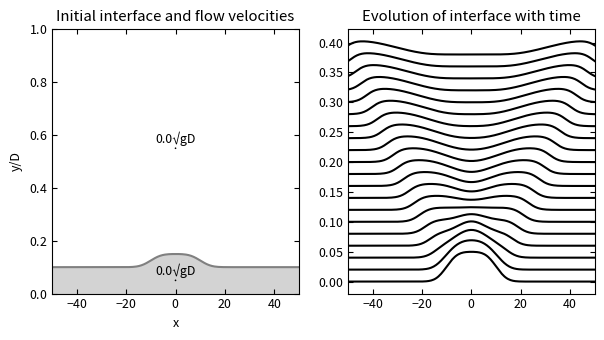

In [53]:
plot_exp(1)

As expected, the perturbation propagates away as two waves, one upstream and one downstream.

Inverting the configuration (experiment 2) shows identical behaviour.

Adding a moderate barotropic flow ($u_{10} = u_{20}$) causes the upstream-propagating flow to be arrested, forming a shock. The downstream-propagating wave is unaffected (other than moving downstream more quickly).

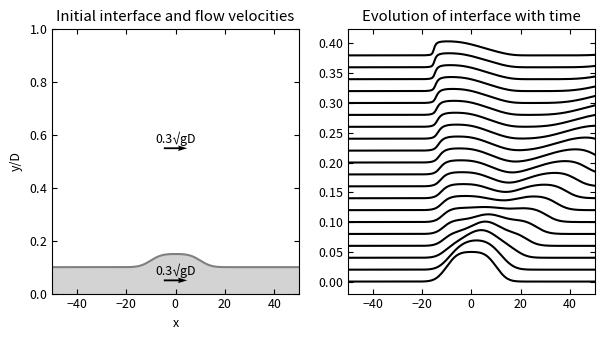

In [55]:
plot_exp(3)

Repeating this experiment but with the velocities in the opposite direction gives similar gross behaviour:

* A shock forms in the same place
* As before, the downstream wave propagates away freely (where downstream is relative to the lower layer flow direction)

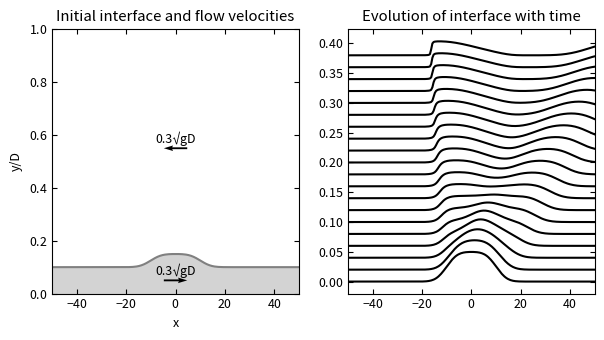

In [56]:
plot_exp(4)

Repeat experiment four, but with the initial perturbation of opposite sign produces the shock at the other end of the perturbation. The centre of the perturbation is now the slowest part of the wave. Therefore, the part of the perturbation to the left is rarefied. The deep part of the bottom layer to the right of the wave travels upstream, but only until it encounters the trough at which time it becomes too slow to propagate upstream.

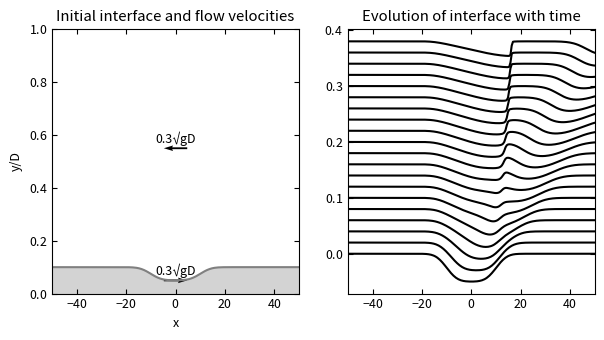

In [57]:
plot_exp(5)

The analysis above could be repeated for various values of $r$, but this produces few conceptual differences. For example, consider experiments 6-8 defined earlier, which repeat experiments 1, 3, and 4 but with a thicker bottom layer (results not shown). The only significant differences are the speed of the interfacial wave, which means that shocks are less likely to occur.

# MITgcm simulations

In [9]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
from xmitgcm import open_mdsdataset
from MyFunctions import get_contour
# Ignore warnings from xmitgcm
warnings.filterwarnings('ignore',".*Couldn't find available_diagnostics.log*.")                                                                                           
warnings.filterwarnings('ignore',".*Not sure what to do with rlev = L*.") 

%matplotlib inline

def waterfall_mitgcm(run_num, ax, Nt=-1, t_step=2, ax_init_conds=None):
    run_dir = './runs/exp' + str(run_num)
    ds = open_mdsdataset(run_dir, prefix=['T', 'U'], delta_t=60).squeeze()
    x_km = ds.XC/1e3

    for i, t_i in enumerate(ds.time[:Nt][::t_step]):
        interface_temp = 2.5  # Mean of top and bottom layers
        interface = get_contour(x_km, ds.Z, ds['T'].isel(time=i).values, 2.5) 
        ax.plot(x_km, interface + 4*i, color='k')
        ax.set(yticks=[], xlabel='Distance (km)')
    
        if ax_init_conds is not None and i == 0:
            ax_ic = ax_init_conds
            ax_ic.fill_between(x_km, interface, -ds.Depth, color='lightgrey')
            ax_ic.plot(x_km, interface, color='grey')
            U0 = ds['U'].isel(time=i)
            j = np.s_[-5::-15]
            if np.mean(U0.values) == 0:
                scat_opts = dict(s=4, color='k')
                ax_ic.scatter(*np.meshgrid(x_km[j], ds.Z[j]), **scat_opts)
            else:
                ax_ic.quiver(x_km[j], ds.Z[j], U0[j, j], np.zeros_like(U0)[j, j])

            ax_ic.set(ylim=(-np.max(ds.Depth), 0), xlim=x_km[[0, -1]],
                      title='Interface and initial velocities',
                      xlabel='Distance (km)')
            
def plot_exp_mitgcm(run_num):
    fig, axs = plt.subplots(ncols=2, sharex=True, figsize=(7, 3.5))
    waterfall_mitgcm(run_num=run_num, ax=axs[1], ax_init_conds=axs[0], Nt=-1) 

The same experiments described above were repeated using the MITgcm. Input files were generated with `./gendata.py`.

In general, I used an ocean of depth 200 m and length 200 km, with an initial perturbation approximately 20 km wide.

I first check the simplest scenario, experiment 1, with no shear.

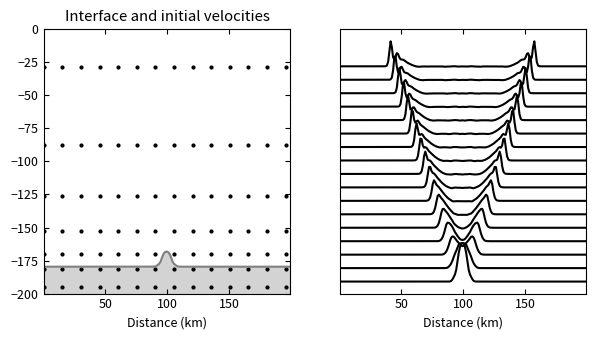

In [10]:
plot_exp_mitgcm(1)

The large-scale behaviour is similar to the results from the method of characteristics. The shape of the wave, however, is different in the MITgcm simulation. Here, the wave has a sharp leading edge with one or two smaller undulations behind it. The exact shape of this wave will depend on parameterisations of mixing and viscosity and the details of the interface between the two layers. The MITgcm, however, has the ability to account for short waves, unlike the method of characteristics, which only treats long waves.

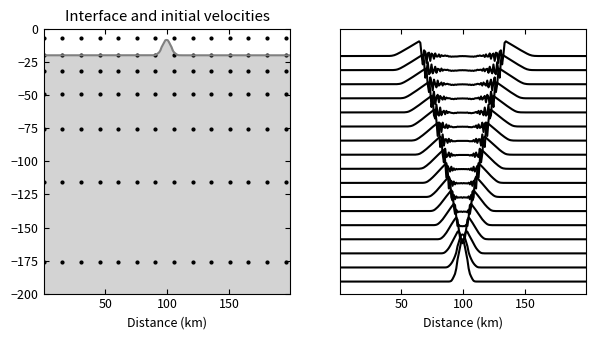

In [12]:
plot_exp_mitgcm(2)

Including shear between the layers (experiment 4) displays the same behaviour: the MITgcm simulation and method of characteristics agree in the large-scale flow features with differences in small-scale features.

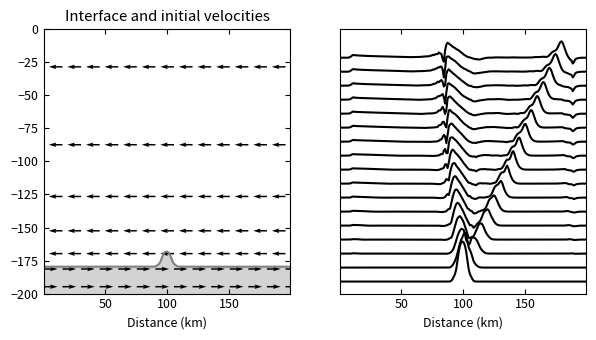

In [15]:
plot_exp_mitgcm(4)

# Hydraulic jump speeds

Here I use a number of two-layer simulations to compare against the jump speed relationships described by
Equations 3.5.11 and 3.5.12 of Baines (1998). Each simulation has an upstream jump caused by an obstacle at
the centre of the x-grid.

I undertake this for $r_u = 0.1$ and $r_u = 0.3$. Input files for these simulations are created in `./gendata.py`

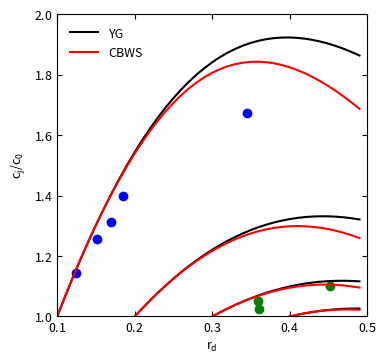

In [22]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from xmitgcm import open_mdsdataset
from MyFunctions import get_contour
# Ignore warnings from xmitgcm
warnings.filterwarnings('ignore',".*Couldn't find available_diagnostics.log*.")                                                                                           
warnings.filterwarnings('ignore',".*Not sure what to do with rlev = L*.")
%matplotlib inline


def jump_from_simulation(run_name, ru):
    """Upstream jump speed and jump amplitude
    
    Returns
    -------
    jump_speed: relative to frame of reference with no velocity upstream, and
    non-dimensionalised by c_0
    rd: fractional depth of bottom layer downstream of jump
    """
    ds = open_mdsdataset('./runs/' + run_name, prefix=['T', 'U'], delta_t=60)
    ds = ds.squeeze()
    x_km = ds.XC/1e3
    interface_temp = 2.5  # Mean of top and bottom layers
   
    x_jump = np.zeros(2)
    time_inds = [5, -1]
    for i, time in enumerate(time_inds): 
        interface = get_contour(x_km.values, ds.Z.values, 
                                ds['T'].isel(time=time).values, interface_temp)  
    
        # Identify jump as largest increase upstream of obstacle
        interface_upstream = np.split(interface, 2)[0]
        x_jump[i] = ds.XC[np.argmax(np.diff(interface_upstream))]
        plt.plot(x_km, interface)
    
    # Simple estimate of downstream depth is 98th percentile of interface.
    # Using max value over estimates.
    D = ds.Depth[0].values
    rd = (D + np.percentile(interface, 98))/D
    jump_speed = np.diff(x_jump)/np.diff(ds.time[time_inds])
    
    # Change frame of reference to jump moving into fluid at rest
    U_bar = ds.U.isel(XG=0).values.mean()
    jump_speed -= U_bar
    
    # Non-dimensionalize
    g = 9.81
    jump_speed /= np.sqrt(ru*(1-ru)*g*delta_rho/rho*D)
    
    return jump_speed, rd


def yg_jump_speed(ru, rd, rho, delta_rho):
    """Jump speed squared scaled by sqrt(g'*D) using Yih and Guha formulation
    
    Equation 3.5.11 of Baines (1998)"""
    
    rho_1 = rho
    rho_2 = rho + delta_rho 
    
    term_1 = (ru + rd)/2
    term_2_denom1 = ru/rd
    term_2_denom2 = rho_2*(1-ru)*(ru+rd)/(rho_1*(1-rd)*(2-ru-rd))
    
    cj2_scaled = term_1/(term_2_denom1 + term_2_denom2)
    
    return np.sqrt(cj2_scaled)


def cbws_jump_speed(ru, rd, rho, delta_rho):
    """Jump speed squared scaled by sqrt(g'*D) using CBWS formulation
    
    Equation 3.5.12 of Baines (1998)"""
    rho_1 = rho
    rho_2 = rho + delta_rho 
   
    numerator = (ru+rd)/2
    denominator = ru/rd + (rho_2/rho_1)*(ru+rd-2*ru*rd)/(2*(1-rd)**2)
    
    cj2_scaled = numerator/denominator
    
    return np.sqrt(cj2_scaled)


def baines_fig3p7():
    """Recreate Figure 3.7 of Baines (1998)"""
    fig, ax = plt.subplots(figsize=(4, 4))
    for ru in np.r_[0.1:0.41:0.1]:

        rd = np.r_[0.1:0.5:0.01]
        c_yg = yg_jump_speed(ru, rd, rho, delta_rho)
        c_cbws = cbws_jump_speed(ru, rd, rho, delta_rho)
        y_axis_scale = np.sqrt(ru*(1-ru))

        yg_line, = ax.plot(rd, c_yg/y_axis_scale, 'k')
        cbws_line, = ax.plot(rd, c_cbws/y_axis_scale, 'r')

    ax.set(xlim=(0.1, 0.5), ylim=(1, 2), ylabel='$c_j/c_0$', xlabel='$r_d$')
    ax.legend([yg_line, cbws_line], ['YG', 'CBWS']);
    
    return fig, ax


# Chosen to match the simulations
rho = 1025
delta_rho = rho/1e3

runs_with_upstream_jump = dict(
    exp_ru_0p1_vel_0p1=0.1,
    exp_ru_0p1_vel_0p2=0.1,
    exp_ru_0p1_vel_0p3=0.1,
    exp_ru_0p1_vel_0p35=0.1,
    exp_ru_0p1_vel_0p4=0.1,
    exp_ru_0p1_vel_0p5=0.1,
    exp_ru_0p3_vel_0p2=0.3,
    exp_ru_0p3_vel_0p3=0.3,
    exp_ru_0p3_vel_0p4=0.3,
    exp_ru_0p3_vel_0p5=0.3)

marker_cols = {0.1:'b', 0.3:'g'}

fig, ax = baines_fig3p7()
for run_name, ru in runs_with_upstream_jump.items():
    cj_over_c0, rd = jump_from_simulation(run_name, ru)

    ax.scatter(rd, -cj_over_c0, color=marker_cols[ru])


The simulated jump speeds fall slightly below the curves. This is somewhat expected based on the description in Baines (1998). He notes that the "bogus" curve in his Figure 3.7 (not shown here) may actually be a better representation of the jump speed, despite dubious physics involved in its derivation. This "bogus" curve lies a little bit below the YG and CBWS curves, and here it would appear to be a better fit to the data.

Some of the discrepancy between curves and data points, however, may result from the relatively crude estimates of $r_d$ and $c_j/c_0$ from the simulations. 